In [70]:
import gdxpds
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [71]:
scenarios = list(['nodal', 'with_instrument', 'without_instrument']);
nodes = list(['north', 'south'])

In [3]:
scenarios = list(['nodal', 'with_instrument', 'without_instrument', 'agnostic_instrument']);

nodes = list(['north', 'south'])

In [72]:
def read_data(file, indicator):
    gams_dir='C:\Program Files\GAMS'
    df = gdxpds.to_dataframes(str(file) + '.gdx', gams_dir=gams_dir)
    df = df[indicator]
    df['model'] = file
    if 'Level' in df.columns:
        df['Value'] = df['Level']
    df['Value'] = df['Value'].round(2)
    return(df.set_index(['model']))

def read(indicator):
    if (len(scenarios) == 4):
        df = read_data(scenarios[0], indicator).append(read_data(scenarios[1], indicator)).append(read_data(scenarios[2], indicator)).append(read_data(scenarios[3], indicator))
    elif (len(scenarios) == 3):
        df = read_data(scenarios[0], indicator).append(read_data(scenarios[1], indicator)).append(read_data(scenarios[2], indicator))
    return(df)
    
def plot_distribution(df, axes, location):
    
    width = 0.8
    #baseload
    
    tmp = df.loc[df['tec'] == 'base'][location].fillna(0)
    tmp = tmp.reindex(index = scenarios)
    leg = axes.barh(y_pos, tmp, width, align='center', color = 'darkred')
    left = tmp.fillna(0)

    #peaker
    tmp = df.loc[df['tec'] == 'peak'][location].fillna(0)
    tmp = tmp.reindex(index = scenarios)
    axes.barh(y_pos, tmp, width, left=left, align='center', color = 'dimgrey')
    left = left + tmp.fillna(0)

    #wind
    tmp = df.loc[df['tec'] == 'wind'][location].fillna(0)
    tmp = tmp.reindex(index = scenarios)
    axes.barh(y_pos, tmp, width, left=left, align='center', color = 'lightblue')
    left = left + tmp.fillna(0)

    #solar
    tmp = df.loc[df['tec'] == 'solar'][location].fillna(0)
    tmp = tmp.reindex(index = scenarios)
    axes.barh(y_pos, tmp, width, left=left, align='center', color = 'gold')
    left = left + tmp.fillna(0)
    #leg.legend()
    return(axes)

    

In [73]:
df = read('o_gen')
df = df.reset_index().set_index(['model','t', 'n','tec'])
df = df.swaplevel().unstack()
df.columns = df.columns.droplevel(0)
df.columns.name = ''

df = df.groupby(['model','tec']).sum()
df = df.reset_index().set_index(['model'])
gen = df

In [74]:
gen

,tec,north,south
model,,,
nodal,base,27.38,306.67
nodal,peak,69.33,18.38
nodal,solar,0.00,32.52
nodal,wind,58.30,25.03
with_instrument,base,31.10,309.09
with_instrument,peak,66.46,15.95
with_instrument,solar,0.00,32.52
with_instrument,wind,58.30,25.03
without_instrument,base,185.17,192.97


In [75]:
gen['total'] = gen['north'] + gen['south']

In [76]:
gen['type'] = ['RE' if tec in ['wind', 'solar'] else 'non RE' for tec in gen['tec']]

In [77]:
re_shares = gen[['total', 'type']].groupby(['model', 'type']).sum()

In [78]:
re_shares = re_shares.unstack()

In [79]:
re_shares

total        
type                    RE  non RE
model                             
nodal               115.85  421.76
with_instrument     115.85  422.60
without_instrument  115.49  422.78

In [80]:
re_shares['total', 'RE'] / (re_shares['total', 'RE'] + re_shares['total', 'non RE'])

model
nodal                 0.215491
with_instrument       0.215155
without_instrument    0.214558
dtype: float64

In [81]:
sums = gen.groupby(['model']).sum()
sums['total'] = sums[nodes[0]] + sums[nodes[1]]
sums = sums /48 * 8760
sums['share north'] = sums[nodes[0]] / sums['total']
sums
# in GWh

,north,south,total,share north
model,,,,
nodal,28289.325,69824.500,98113.825,0.288332
with_instrument,28444.450,69822.675,98267.125,0.289460
without_instrument,54324.775,43909.500,98234.275,0.553012


# Installed capacities

In [82]:
df = read('o_cap')
df = df.reset_index().set_index(['model', 'n','tec'])
df = df.swaplevel().unstack()
df.columns = df.columns.droplevel(0)
df.columns.name = ''
df = df.reset_index().set_index(['model'])
capacities = df

In [83]:
capacities

,tec,north,south
model,,,
nodal,base,3.11,31.50
nodal,peak,15.39,3.54
nodal,solar,NaN,27.32
nodal,wind,27.76,14.22
with_instrument,base,3.11,31.50
with_instrument,peak,15.39,3.54
with_instrument,solar,0.00,27.32
with_instrument,wind,27.76,14.22
without_instrument,base,19.88,19.88


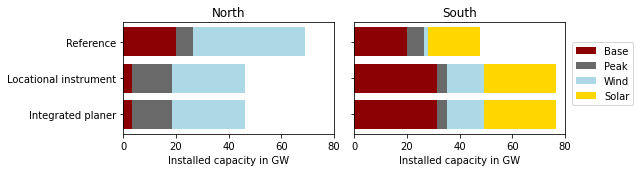

In [86]:
#plt.rcdefaults()
fig = plt.figure(figsize=(9, 2.5))

ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

y_pos = np.arange(len(scenarios))
#leg = pd.Dataframe()

plot_distribution(capacities, ax1, 'north')
axes = plot_distribution(capacities, ax2, 'south')

ax1.set_xlim(0, 80)
ax2.set_xlim(0, 80)

ax1.set_title('North')
ax2.set_title('South')
                        
ax2.legend(['Base', 'Peak', 'Wind', 'Solar'], bbox_to_anchor=(1.01, 0.87))
ax1.set_yticks(y_pos);

ax1.set_yticklabels(['Integrated planer', 'Locational instrument', 'Reference'])
ax2.set_yticklabels([]);
ax1.set_xlabel('Installed capacity in GW')
ax2.set_xlabel('Installed capacity in GW')
plt.tight_layout()

fig.savefig('Figures/capacity_distribution.jpeg', dpi=500)

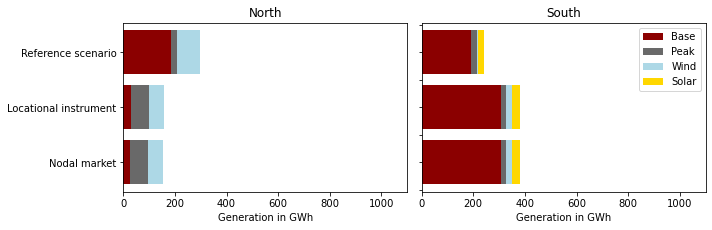

In [59]:
# plot generation
#plt.rcdefaults()
fig = plt.figure(figsize=(10, 3.3))

ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

y_pos = np.arange(len(scenarios))
#leg = pd.Dataframe()

plot_distribution(gen, ax1, nodes[0])
axes = plot_distribution(gen, ax2, nodes[1])

ax1.set_xlim(0, 1100)
ax2.set_xlim(0, 1100)

ax1.set_title('North')
ax2.set_title('South')
                        
ax2.legend(['Base', 'Peak', 'Wind', 'Solar'], bbox_to_anchor=(1.0, 1))
#ax1.legend(['Base', 'Peak', 'Wind', 'Solar'])
ax1.set_yticks(y_pos);

if len(scenarios) == 3:
    ax1.set_yticklabels(['Nodal market', 'Locational instrument', 'Reference scenario']);
    
if len(scenarios) == 4:
    ax1.set_yticklabels(['Nodal market', 'Locational instrument', 'Reference scenario', 'Agnostic instrument']);
    
ax2.set_yticklabels([]);
ax1.set_xlabel('Generation in GWh')
ax2.set_xlabel('Generation in GWh')
plt.tight_layout()

fig.savefig('generation_distribution.jpeg', dpi=500)

# Welfare comparison

In [89]:
scenarios = list(['nodal', 'with_instrument', 'without_instrument', 'small_instrument', 'large_instrument', 'agnostic_instrument',  'with_instrument_redispatch', 'without_instrument_redispatch']);


welfare = pd.DataFrame(index = scenarios, columns = ['Generation cost', 'Network cost', 'Total costs', 'Gross consumer surplus'])

for scenario in scenarios:
    welfare.loc[scenario, 'Generation cost'] = read_data(scenario, 'generation_costs').iloc[0,0]
    welfare.loc[scenario, 'Network cost'] = read_data(scenario, 'network_cost').iloc[0,0]
    welfare.loc[scenario, 'Total costs'] = welfare.loc[scenario, 'Network cost'] + welfare.loc[scenario, 'Generation cost'] 
    welfare.loc[scenario, 'Gross consumer surplus'] = read_data(scenario, 'consumer_surplus').iloc[0,0]
    
welfare['Welfare'] = welfare['Gross consumer surplus'] - welfare['Network cost'] - welfare['Generation cost'];
welfare = welfare / 1000

welfare.style.format('{0:,.1f}')

,Generation cost,Network cost,Total costs,Gross consumer surplus,Welfare
nodal,40.9,1.0,41.9,331.7,289.8
with_instrument,40.8,1.2,42.0,331.7,289.8
without_instrument,40.5,3.4,43.9,331.7,287.8
small_instrument,40.7,1.5,42.2,331.7,289.6
large_instrument,40.9,1.4,42.3,331.8,289.4
agnostic_instrument,40.6,2.1,42.6,331.7,289.1
with_instrument_redispatch,40.8,1.3,42.0,331.7,289.7
without_instrument_redispatch,40.6,3.7,44.3,331.7,287.4


In [61]:
print('welfare gains through instrument in %')
print(round((welfare['Welfare']['with_instrument'] - welfare['Welfare']['without_instrument']) / welfare['Welfare']['without_instrument'] * 100,1))

print('Cost savings through instrument in %')
print(round((welfare['Total costs']['with_instrument'] - welfare['Total costs']['without_instrument']) / welfare['Total costs']['without_instrument'] * 100,1))

print('welfare gains through nodal pricing in %')
print(round((welfare['Welfare']['nodal'] - welfare['Welfare']['without_instrument']) / welfare['Welfare']['without_instrument'] * 100,1))

print('Cost savings through nodal pricing in %')
print(round((welfare['Total costs']['nodal'] - welfare['Total costs']['without_instrument']) / welfare['Total costs']['without_instrument'] * 100,1))


if len(scenarios) > 3:
    print('welfare gain through uniform signal in %')
    print(round((welfare['Welfare']['agnostic_instrument'] - welfare['Welfare']['without_instrument']) / (welfare['Welfare']['with_instrument'] - welfare['Welfare']['without_instrument']) * 100,1))

if len(scenarios) > 3:
    print('Cost savings through uniform signal in %')
    print(round((welfare['Total costs']['agnostic_instrument'] - welfare['Total costs']['without_instrument']) / (welfare['Total costs']['with_instrument'] - welfare['Total costs']['without_instrument']) * 100,1))


welfare gains through instrument in %
0.7
Cost savings through instrument in %
-4.3
welfare gains through nodal pricing in %
0.7
Cost savings through nodal pricing in %
-4.5
welfare gain through uniform signal in %
64.2
Cost savings through uniform signal in %
66.2


# Instrument level

In [38]:
fixed_costs = read_data('with_instrument', 'c_fix').reset_index(drop = True).set_index(['tec','n']).unstack()
fixed_costs.columns = fixed_costs.columns.droplevel(0)

In [39]:
fixed_costs

n,north,south
tec,,
base,342.0,342.0
peak,126.0,126.0
solar,68.0,68.0
wind,114.0,114.0


In [40]:
instr = read_data('with_instrument', 'o_instrument').reset_index(drop = True).set_index(['tec','n']).unstack()
instr.columns = instr.columns.droplevel(0)
instr = instr.round(1)

In [41]:
instr

n,north,south
tec,,
base,12.3,2.8
peak,-13.5,-9.5
solar,1.4,2.8
wind,11.1,0.8


In [128]:
cap = read_data('with_instrument', 'o_cap').reset_index(drop = True).set_index(['tec','n']).unstack()
cap.columns = cap.columns.droplevel(0)
instr[cap.isna()] = np.nan

In [74]:
shares = round(100 *instr / fixed_costs,1)

In [75]:
shares = shares.rename(columns={'north':'north (share)', 'south': 'south (share)'})
#shares.columns = shares.columns.droplevel(0)

In [76]:
shares

n,north (share),south (share)
tec,,
base,11.8,8.0
peak,-8.7,-4.6
solar,30.4,20.9
wind,14.4,3.8


In [77]:
instrument = pd.concat([instr, shares], axis=1)
instrument = instrument.sort_index(axis = 1)

In [78]:
#fixed_costs.columns = fixed_costs.columns.droplevel(0)
instrument['Fixed cost'] = fixed_costs['north']

In [79]:
format_dict = {'north':'{0:,.0f} €', 'north (share)': '{0:,.0f}%', 'south': '{0:,.0f} €', 'south (share)': '{0:,.0f}%', 'Fixed cost': '{0:,.0f} €'}
instrument.style.format(format_dict)

n,north,north (share),south,south (share),Fixed cost
tec,,,,,
base,32 €,12%,22 €,8%,274 €
peak,-9 €,-9%,-5 €,-5%,100 €
solar,17 €,30%,12 €,21%,55 €
wind,13 €,14%,4 €,4%,91 €


# Redispatch

In [32]:
cap = read_data('with_instrument', 'o_cap')

In [33]:
cap2 = read_data('with_instrument_redispatch', 'o_cap')

In [34]:
cap

,tec,n,Value
model,,,
with_instrument,base,north,3.11
with_instrument,base,south,31.50
with_instrument,peak,north,15.39
with_instrument,peak,south,3.54
with_instrument,wind,north,27.76
with_instrument,wind,south,14.22
with_instrument,solar,north,0.00
with_instrument,solar,south,27.32


In [35]:
cap2

,tec,n,Value
model,,,
with_instrument_redispatch,base,north,4.10
with_instrument_redispatch,base,south,31.27
with_instrument_redispatch,peak,north,12.23
with_instrument_redispatch,peak,south,5.74
with_instrument_redispatch,wind,north,31.92
with_instrument_redispatch,wind,south,12.95
with_instrument_redispatch,solar,north,0.00
with_instrument_redispatch,solar,south,16.89


In [36]:
dif = cap2.set_index(['tec', 'n']) - cap.set_index(['tec', 'n'])

In [37]:
dif

Value
tec   n           
base  north   0.99
      south  -0.23
peak  north  -3.16
      south   2.20
wind  north   4.16
      south  -1.27
solar north   0.00
      south -10.43